In [1]:
!pip install gluonnlp pandas tqdm   
!pip install mxnet
!pip install sentencepiece==0.1.91
!pip install transformers==4.8.2
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached sentencepiece-0.1.91.tar.gz (500 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.8.2-py3-none-any.whl (2.5 MB)
  Attem

In [2]:
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-ee080tic/kobert-tokenizer_44fa43ce488749be87790ffb1a841653
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-ee080tic/kobert-tokenizer_44fa43ce488749be87790ffb1a841653
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done


In [3]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-3yxkmzod
  Running command git clone --filter=blob:none --quiet 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-3yxkmzod
  Resolved https://****@github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done
  Using cached transformers-4.8.1-py3-none-any.whl (2.5 MB)
  Attempting uninstall: transformers
    Found existing installation: transformers 4.8.2
    Uninstalling transformers-4.8.2:
      Successfully uninstalled transformers-4.8.2


In [4]:
!pip install python-mecab-ko

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from kobert_tokenizer import KoBERTTokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel, vocab = get_pytorch_kobert_model()

using cached model. /content/.cache/kobert_v1.zip
using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [6]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook
import pandas as pd

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
from transformers import BertModel

#GPU 사용 시
device = torch.device("cuda:0")

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from mecab import MeCab
import warnings
warnings.filterwarnings("ignore")

In [9]:
# data_path = '/content/drive/MyDrive/에이블스쿨/실습파일/2023.04.03_미니프로젝트4차_실습자료/data/train.csv'
data_path = '/content/drive/MyDrive/에이블스쿨/미니프로젝트_4차/dataset/train.csv'
data = pd.read_csv(data_path)

In [10]:
label_dict = {
    '코드1': 0,
    '코드2': 0,
    '웹': 1,
    '이론': 2,
    '시스템 운영': 3,
    '원격': 4
}

data = data.replace(label_dict)
data.head()

,text,label
0,"self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ...",0
1,현재 이미지를 여러개 업로드 하기 위해 자바스크립트로 동적으로 폼 여러개 생성하는데...,1
2,glob.glob(PATH) 를 사용할 때 질문입니다.\n\nPATH에 [ ] 가 ...,0
3,"tmpp = tmp.groupby(by = 'Addr1', as_index=Fals...",0
4,filename = TEST_IMAGE + str(round(frame_sec)) ...,0


In [11]:
mecab = MeCab()
result = []
for i in data['text']:
    temp = [x[0] for x in mecab.pos(i)]
    result.append(' '.join(temp))
data['text'] = result

In [12]:
data['text'][0]

'self . convs 1 = nn . ModuleList ( [ nn . Conv 2 d ( 1 , Co , ( K , 100 ) ) for K in Ks ] ) 1 . 여기 서 커널 사이즈 K , 100 은 한 단어 의 최대 길이 가 100 이 넘 지 않 는다는 가정 으로 그냥 100 으로 선언 한 것 인지 궁금 합니다 .'

In [13]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer,vocab, max_len,
                 pad, pair):
   
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)
        
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))
         

    def __len__(self):
        return (len(self.labels))

In [14]:
# Setting parameters
max_len = 200
batch_size = 32
warmup_ratio = 0.1
num_epochs = 100
max_grad_norm = 1
log_interval = 20
learning_rate =  5e-5

In [15]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(
    data['text'], data['label'], test_size=0.1,
    random_state=2023, stratify=data['label'])

In [16]:
dataset_train = []
for sen, label in zip(x_train, y_train):
    dataset_train.append((sen, str(label)))
dataset_val = []
for sen, label in zip(x_val, y_val):
    dataset_val.append((sen, str(label)))

In [17]:
tk = tokenizer.tokenize
data_train = BERTDataset(dataset_train, 0, 1, tk, vocab, max_len, True, False)
data_val = BERTDataset(dataset_val, 0, 1, tk, vocab, max_len, True, False)

In [18]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(data_val, batch_size=batch_size, num_workers=5)

In [19]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=5,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device),return_dict=False)
        if self.dr_rate:
            out = self.dropout(pooler)
        else:
            out = pooler
        return self.classifier(out)

In [20]:
#BERT 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)
 
#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss() # 다중분류를 위한 대표적인 loss func

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [21]:
# Early Stopping
best_loss = 10 ** 9 # 매우 큰 값으로 초기값 가정
patience_limit = 5 # 몇 번의 epoch까지 지켜볼지를 결정
patience_check = 0 # 현재 몇 epoch 연속으로 loss 개선이 안되는지를 기록

train_history=[]
val_history=[]
train_loss_history=[]
val_loss_history=[]
for e in range(num_epochs):
    train_acc, train_loss = 0.0, 0.0
    val_acc, val_loss = 0.0, 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
         
        #print(label.shape,out.shape)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        train_loss += loss.data.cpu().numpy()
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
            # train_history.append(train_acc / (batch_id+1))
            # train_loss_history.append(loss.data.cpu().numpy())
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    print("epoch {} train loss {}".format(e+1, train_loss / (batch_id+1)))
    train_history.append(train_acc / (batch_id+1))
    train_loss_history.append(train_loss / (batch_id+1))
    
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        val_acc += calc_accuracy(out, label)
        val_loss += loss_fn(out, label).data.cpu().numpy()
    print("epoch {} val acc {}".format(e+1, val_acc / (batch_id+1)))
    print("epoch {} val loss {}".format(e+1, val_loss / (batch_id+1)))
    val_history.append(val_acc / (batch_id+1))
    val_loss_history.append(val_loss / (batch_id+1))

    ### early stopping 여부를 체크하는 부분 ###
    if val_loss > best_loss: # loss가 개선되지 않은 경우
        patience_check += 1

        if patience_check >= patience_limit: # early stopping 조건 만족 시 조기 종료
            break

    else: # loss가 개선된 경우
        best_loss = val_loss
        patience_check = 0

  0%|          | 0/105 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.5074876546859741 train acc 0.25
epoch 1 batch id 21 loss 1.6603621244430542 train acc 0.23958333333333334
epoch 1 batch id 41 loss 1.4577440023422241 train acc 0.2804878048780488
epoch 1 batch id 61 loss 1.596893548965454 train acc 0.3043032786885246
epoch 1 batch id 81 loss 1.4122812747955322 train acc 0.3341049382716049
epoch 1 batch id 101 loss 1.3804166316986084 train acc 0.349009900990099
epoch 1 train acc 0.3524659863945578
epoch 1 train loss 1.4717789661316645


  0%|          | 0/12 [00:00<?, ?it/s]

epoch 1 val acc 0.44394188596491224
epoch 1 val loss 1.2986395458380382


  0%|          | 0/105 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 1.3157755136489868 train acc 0.46875
epoch 2 batch id 21 loss 1.1299664974212646 train acc 0.4479166666666667
epoch 2 batch id 41 loss 1.2485156059265137 train acc 0.4649390243902439
epoch 2 batch id 61 loss 1.0858114957809448 train acc 0.5020491803278688
epoch 2 batch id 81 loss 1.115910530090332 train acc 0.5239197530864198
epoch 2 batch id 101 loss 1.1724834442138672 train acc 0.541769801980198
epoch 2 train acc 0.5441326530612245
epoch 2 train loss 1.1782852632658822


  0%|          | 0/12 [00:00<?, ?it/s]

epoch 2 val acc 0.6378837719298246
epoch 2 val loss 1.015636647741


  0%|          | 0/105 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 1.0395922660827637 train acc 0.59375
epoch 3 batch id 21 loss 1.0973931550979614 train acc 0.6324404761904762
epoch 3 batch id 41 loss 0.8078216910362244 train acc 0.6547256097560976
epoch 3 batch id 61 loss 0.8376338481903076 train acc 0.6782786885245902
epoch 3 batch id 81 loss 0.7766594886779785 train acc 0.6890432098765432
epoch 3 batch id 101 loss 0.9388375282287598 train acc 0.6918316831683168
epoch 3 train acc 0.6962585034013605
epoch 3 train loss 0.8831368588265919


  0%|          | 0/12 [00:00<?, ?it/s]

epoch 3 val acc 0.7012061403508771
epoch 3 val loss 0.7940403372049332


  0%|          | 0/105 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.7228537201881409 train acc 0.71875
epoch 4 batch id 21 loss 0.7014521360397339 train acc 0.7678571428571429
epoch 4 batch id 41 loss 0.5924791693687439 train acc 0.7721036585365854
epoch 4 batch id 61 loss 0.7641879916191101 train acc 0.7838114754098361
epoch 4 batch id 81 loss 0.4973323941230774 train acc 0.7893518518518519
epoch 4 batch id 101 loss 0.811456561088562 train acc 0.7920792079207921
epoch 4 train acc 0.7955357142857142
epoch 4 train loss 0.6269625804253987


  0%|          | 0/12 [00:00<?, ?it/s]

epoch 4 val acc 0.7837171052631579
epoch 4 val loss 0.6105069766441981


  0%|          | 0/105 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.43274354934692383 train acc 0.84375
epoch 5 batch id 21 loss 0.5564295649528503 train acc 0.8526785714285714
epoch 5 batch id 41 loss 0.36378031969070435 train acc 0.8551829268292683
epoch 5 batch id 61 loss 0.5145333409309387 train acc 0.8539959016393442
epoch 5 batch id 81 loss 0.3222799003124237 train acc 0.8483796296296297
epoch 5 batch id 101 loss 0.5374094247817993 train acc 0.8462252475247525
epoch 5 train acc 0.8482142857142857
epoch 5 train loss 0.46307808274314516


  0%|          | 0/12 [00:00<?, ?it/s]

epoch 5 val acc 0.8141447368421053
epoch 5 val loss 0.5738981366157532


  0%|          | 0/105 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.3182883560657501 train acc 0.90625
epoch 6 batch id 21 loss 0.3888454735279083 train acc 0.8913690476190477
epoch 6 batch id 41 loss 0.16458407044410706 train acc 0.8948170731707317
epoch 6 batch id 61 loss 0.5477184653282166 train acc 0.8939549180327869
epoch 6 batch id 81 loss 0.2103898525238037 train acc 0.8942901234567902
epoch 6 batch id 101 loss 0.16656999289989471 train acc 0.8948019801980198
epoch 6 train acc 0.891921768707483
epoch 6 train loss 0.34396717278730304


  0%|          | 0/12 [00:00<?, ?it/s]

epoch 6 val acc 0.8427905701754387
epoch 6 val loss 0.5182116689781348


  0%|          | 0/105 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.2990243434906006 train acc 0.90625
epoch 7 batch id 21 loss 0.30365943908691406 train acc 0.9345238095238095
epoch 7 batch id 41 loss 0.1945728361606598 train acc 0.9184451219512195
epoch 7 batch id 61 loss 0.4567497670650482 train acc 0.9221311475409836
epoch 7 batch id 81 loss 0.3039003908634186 train acc 0.9124228395061729
epoch 7 batch id 101 loss 0.4996415376663208 train acc 0.9087252475247525
epoch 7 train acc 0.9104166666666667
epoch 7 train loss 0.28218433725691977


  0%|          | 0/12 [00:00<?, ?it/s]

epoch 7 val acc 0.8245614035087719
epoch 7 val loss 0.5724316301445166


  0%|          | 0/105 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.24020960927009583 train acc 0.9375
epoch 8 batch id 21 loss 0.1094166561961174 train acc 0.9494047619047619
epoch 8 batch id 41 loss 0.2030380368232727 train acc 0.9451219512195121
epoch 8 batch id 61 loss 0.3091003894805908 train acc 0.9451844262295082
epoch 8 batch id 81 loss 0.10449019074440002 train acc 0.9421296296296297
epoch 8 batch id 101 loss 0.17990800738334656 train acc 0.9402846534653465
epoch 8 train acc 0.9401785714285714
epoch 8 train loss 0.19990156409995896


  0%|          | 0/12 [00:00<?, ?it/s]

epoch 8 val acc 0.8349780701754387
epoch 8 val loss 0.579306156684955


  0%|          | 0/105 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.2857263684272766 train acc 0.9375
epoch 9 batch id 21 loss 0.18596157431602478 train acc 0.9568452380952381
epoch 9 batch id 41 loss 0.026533864438533783 train acc 0.9512195121951219
epoch 9 batch id 61 loss 0.1375236064195633 train acc 0.9508196721311475
epoch 9 batch id 81 loss 0.16381222009658813 train acc 0.9471450617283951
epoch 9 batch id 101 loss 0.24140454828739166 train acc 0.943069306930693
epoch 9 train acc 0.9434523809523809
epoch 9 train loss 0.18677915600793701


  0%|          | 0/12 [00:00<?, ?it/s]

epoch 9 val acc 0.8219572368421053
epoch 9 val loss 0.6508739988009135


  0%|          | 0/105 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.03821609541773796 train acc 1.0
epoch 10 batch id 21 loss 0.11156779527664185 train acc 0.9523809523809523
epoch 10 batch id 41 loss 0.12387824058532715 train acc 0.9550304878048781
epoch 10 batch id 61 loss 0.3665635883808136 train acc 0.9523565573770492
epoch 10 batch id 81 loss 0.6435033679008484 train acc 0.9556327160493827
epoch 10 batch id 101 loss 0.15696047246456146 train acc 0.9535891089108911
epoch 10 train acc 0.9550595238095239
epoch 10 train loss 0.1575866691679472


  0%|          | 0/12 [00:00<?, ?it/s]

epoch 10 val acc 0.8393640350877193
epoch 10 val loss 0.6544624579449495


  0%|          | 0/105 [00:00<?, ?it/s]

epoch 11 batch id 1 loss 0.3345572352409363 train acc 0.9375
epoch 11 batch id 21 loss 0.105607770383358 train acc 0.9657738095238095
epoch 11 batch id 41 loss 0.25863325595855713 train acc 0.9634146341463414
epoch 11 batch id 61 loss 0.4967142939567566 train acc 0.9574795081967213
epoch 11 batch id 81 loss 0.8067294359207153 train acc 0.9579475308641975
epoch 11 batch id 101 loss 0.12231917679309845 train acc 0.9554455445544554
epoch 11 train acc 0.9528061224489797
epoch 11 train loss 0.17085281447285697


  0%|          | 0/12 [00:00<?, ?it/s]

epoch 11 val acc 0.8463541666666666
epoch 11 val loss 0.6592383664101362


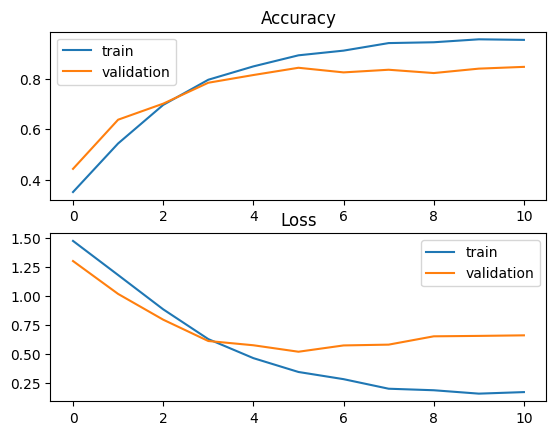

In [22]:
plt.subplot(2, 1, 1)
plt.title('Accuracy')
plt.plot(train_history, label='train')
plt.plot(val_history, label='validation')
plt.legend()

plt.subplot(2, 1, 2)
plt.title('Loss')
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='validation')
plt.legend()
plt.show()

In [27]:
data_path = '/content/drive/MyDrive/에이블스쿨/미니프로젝트_4차/dataset/test.csv'
data = pd.read_csv(data_path)

mecab = MeCab()
result = []
for i in data['text']:
    temp = [x[0] for x in mecab.pos(i)]
    result.append(' '.join(temp))
data['text'] = result

dataset_test = []
for sen in data['text']:
    dataset_test.append((sen, 0))

data_test = BERTDataset(dataset_test, 0, 1, tk, vocab, max_len, True, False)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

In [28]:
model.eval()
test_acc = 0.0
y_pred = []
y_test = []
for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length= valid_length
    label = label.long().to(device)
    out = model(token_ids, valid_length, segment_ids)
    test_acc += calc_accuracy(out, label)
    y_test = np.hstack((y_test, label.cpu().numpy()))
    y_pred = np.hstack((y_pred, torch.max(out, 1)[1].cpu().numpy()))

  0%|          | 0/30 [00:00<?, ?it/s]

In [38]:
result = pd.DataFrame(y_pred.astype(int), columns=['label']).reset_index().rename(columns={'index' : 'id'})
result

,id,label
0,0,3
1,1,3
2,2,0
3,3,0
4,4,0
...,...,...
924,924,3
925,925,0
926,926,3
927,927,1


In [40]:
save_path = '/content/drive/MyDrive/에이블스쿨/미니프로젝트_4차/result/'
result.to_csv(save_path + 'kobert_morph.csv', index=False)